From the article : https://towardsdatascience.com/finding-the-best-wordle-opener-with-machine-learning-ce81331c5759

![](https://cdn1.dotesports.com/wp-content/uploads/2022/02/07114240/Wordle.jpg)

In [1]:
!pip install pyod

     |████████████████████████████████| 114 kB 4.4 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for pyod: filename=pyod-0.9.8-py3-none-any.whl size=136773 sha256=3fb0e4790a4a00c8c2ee02200e566be7af42c9c5cd49568499df7cc5e38eb469
  Stored in directory: /root/.cache/pip/wheels/ba/8f/95/6cb376aec9fae09d9b1622d1662c902b522deb353cb80836a6
Successfully built pyod


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from collections import Counter
from tqdm import tqdm
from pyod.models.copod import COPOD

Getting the wordlists

In [3]:
!wget https://raw.githubusercontent.com/hfhoffman1144/Best-Wordle-Opener-ML/main/possible_answers.txt 
!wget https://raw.githubusercontent.com/hfhoffman1144/Best-Wordle-Opener-ML/main/accepted_words.txt

--2022-03-28 18:12:02--  https://raw.githubusercontent.com/hfhoffman1144/Best-Wordle-Opener-ML/main/possible_answers.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13889 (14K) [text/plain]
Saving to: ‘possible_answers.txt’

possible_answers.tx 100%[===================>]  13.56K  --.-KB/s    in 0s      

2022-03-28 18:12:02 (30.5 MB/s) - ‘possible_answers.txt’ saved [13889/13889]

--2022-03-28 18:12:03--  https://raw.githubusercontent.com/hfhoffman1144/Best-Wordle-Opener-ML/main/accepted_words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response

In [4]:
 def read_word_list(file_name:str):
    result = []
    with open(file_name) as fp:
        result.extend([word.strip() for word in fp.readlines()])
    return result
# Read in word lists
possible_words_list = read_word_list("possible_answers.txt")
accepted_words_list = read_word_list("accepted_words.txt")

In [5]:
# Create a letter occurrence dictionary 
words_string = ''.join(accepted_words_list)
letter_counts = dict(Counter(words_string))
# Create letter frequency dictionary
letter_frequencies = {k:v/len(accepted_words_list) for k,v in letter_counts.items()}
# Create letter frequency DataFrame
letter_frequencies = pd.DataFrame({'Letter':list(letter_frequencies.keys()),'Frequency':list(letter_frequencies.values())}).sort_values('Frequency',                                                                                  ascending=False)

In [6]:
letter_frequencies

,Letter,Frequency
12,s,0.513799
2,e,0.513568
0,a,0.461764
18,o,0.342121
6,r,0.320537
5,i,0.289778
4,l,0.259867
8,t,0.254009
16,n,0.227567
20,u,0.193571


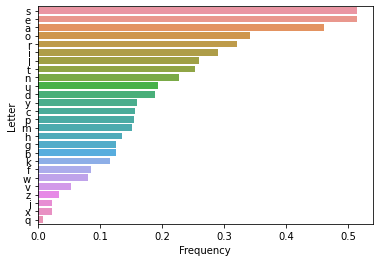

In [7]:
ax = sns.barplot(x="Frequency", y="Letter", data=letter_frequencies)

Tarticle notes that "Initially, one might be tempted to use the raw frequencies as a way of coming up with a good initial guess. For instance, our initial guess could be “soare” based on the fact that “soare” contains the top 5 most frequently found letters. The problem with this is that it doesn’t consider the relative orderings of letters. In the case of “soare”, it’s very rare that a word contains an “o” followed by an “a”. In fact, this only happens in 23 of the 2,315 “possible words”"

But checking in the actual list provided it happens in a lot of cases.


In [8]:
counter = 0
for i in accepted_words_list:
    for j, letter in enumerate(i):
        if letter=='o' and j != len(i)-1:
            if(i[j+1]=='a'):
                    print(counter, i)
                    counter += 1
            

0 anoas
1 bloat
2 boabs
3 boaks
4 board
5 boars
6 boart
7 boast
8 boats
9 booai
10 booay
11 broad
12 cloak
13 cloam
14 coach
15 coact
16 coady
17 coala
18 coals
19 coaly
20 coapt
21 coarb
22 coast
23 coate
24 coati
25 coats
26 cocoa
27 croak
28 doabs
29 doats
30 float
31 foals
32 foams
33 foamy
34 genoa
35 gloam
36 gloat
37 goads
38 goafs
39 goals
40 goary
41 goats
42 goaty
43 groan
44 groat
45 hoaed
46 hoagy
47 hoard
48 hoars
49 hoary
50 hoast
51 koala
52 koans
53 koaps
54 loach
55 loads
56 loafs
57 loams
58 loamy
59 loans
60 loast
61 loath
62 loave
63 moans
64 moats
65 noahs
66 oaked
67 oaken
68 oaker
69 oakum
70 oared
71 oases
72 oasis
73 oasts
74 oaten
75 oater
76 oaths
77 oaves
78 ploat
79 poach
80 poaka
81 poake
82 proas
83 psoae
84 psoai
85 psoas
86 quoad
87 roach
88 roads
89 roams
90 roans
91 roars
92 roary
93 roast
94 roate
95 shoal
96 shoat
97 skoal
98 sloan
99 soaks
100 soaps
101 soapy
102 soare
103 soars
104 soave
105 stoae
106 stoai
107 stoas
108 stoat
109 toads
110 toady


# one hot encoded word data

In [9]:
# Create a list of each letter in the alphabet
ALPHABET = list(string.ascii_lowercase)
ALPHABET

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [10]:
letter_freq_cols = []
for letter in ALPHABET:
    for position in range(5):
        letter_freq_cols.append(f'{letter}{position}')

We shall look at the positional frequency of each letter, i.e in each 5 letter word what is the probablitiy of each alphabet.

In [11]:
# Create letter/position occurrence matrix
letter_pos_freq = pd.DataFrame()

# For each word in the list of accepted words
for word in tqdm(accepted_words_list):
    
    # Convert the word to it letter-position format
    word_and_pos = ''.join([f"{letter}{pos}" for pos, letter in enumerate(word)])
    
    # Create letter-position counter dictionary
    letter_pos_counter = {}
    for wp in letter_freq_cols:
        letter_pos_counter[wp] = len(re.findall(wp, word_and_pos))

    tmp_pos_freq = pd.DataFrame(letter_pos_counter, index=[word])
    letter_pos_freq = pd.concat([letter_pos_freq, tmp_pos_freq])
    
letter_pos_freq.head()

100%|██████████| 12972/12972 [01:03<00:00, 204.66it/s]


,a0,a1,a2,a3,a4,b0,b1,b2,b3,b4,...,y0,y1,y2,y3,y4,z0,z1,z2,z3,z4
aahed,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aalii,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aargh,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aarti,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abaca,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
letter_pos_freq

,a0,a1,a2,a3,a4,b0,b1,b2,b3,b4,...,y0,y1,y2,y3,y4,z0,z1,z2,z3,z4
aahed,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aalii,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aargh,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aarti,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abaca,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuzim,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
zygal,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
zygon,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
zymes,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [13]:
# What's the probability that the first letter is 'a'?
print(letter_pos_freq['a0'].mean())

# What's the probability that 'a' is in the word?
print(len(letter_pos_freq.query('a0==1 or a1==1 or a2==1 or a3==1 or a4==1')) / len(letter_pos_freq))

# What's the probability that the second letter is 'h' given that the first letter is s?
print(letter_pos_freq.query('s0 == 1')['h1'].mean())

# What's the probability that the fourth letter is 'r' given that the first three letter are 's','h', and 'a'?
print(letter_pos_freq.query('s0 == 1 and h1 == 1 and a2 == 1')['r3'].mean())

0.05681467776749923
0.41088498304039467
0.09456869009584665
0.13157894736842105


In [14]:
letter_pos_freq_possible = letter_pos_freq[letter_pos_freq.index.isin(possible_words_list)]

# Drop columns with all zeros
for col in letter_pos_freq_possible.columns:
    
    if letter_pos_freq_possible[col].sum() == 0:
        letter_pos_freq_possible.drop(col, axis=1, inplace=True)
        letter_pos_freq.drop(col, axis=1, inplace=True)
        
letter_pos_freq_possible.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,a0,a1,a2,a3,a4,b0,b1,b2,b3,b4,...,y0,y1,y2,y3,y4,z0,z1,z2,z3,z4
aback,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abase,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abate,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abbey,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
abbot,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
letter_pos_freq_possible.query('o2==1 and o3==1').shape[0] / letter_pos_freq_possible.shape[0]

0.013390928725701945

In [16]:
[word for word in possible_words_list if (word[2]=='t') & ('r' in word) & ('a' in word) &('e' not in word)]

['actor', 'altar', 'artsy', 'ratio', 'ratty', 'satyr', 'ultra']

In [17]:
# Fit COPOD model
copod_model = COPOD(contamination=0.01)
copod_model.fit(letter_pos_freq_possible)

COPOD(contamination=0.01, n_jobs=1)

In [18]:
letter_pos_freq_possible['score'] = copod_model.decision_scores_
letter_pos_freq_possible.sort_values('score',inplace=True)

letter_pos_freq_possible['rank'] = range(1,len(letter_pos_freq_possible)+1)
letter_pos_freq_possible.head(30)[['score','rank']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,score,rank
saint,13.084424,1
slate,13.089547,2
slice,13.150602,3
sooty,13.156166,4
crane,13.165940,5
sauce,13.213513,6
shale,13.277906,7
saute,13.305916,8
shine,13.310287,9
suite,13.324098,10


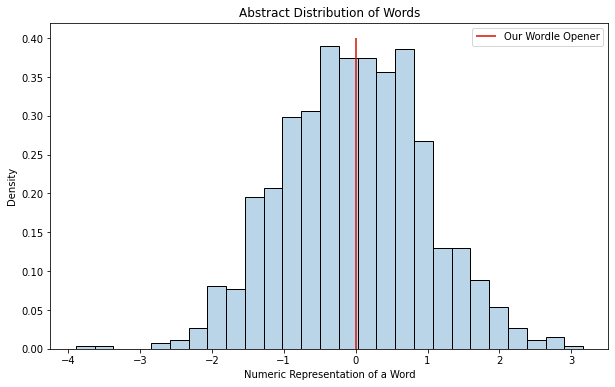

In [19]:
fig,ax = plt.subplots(figsize=(10,6))
sns.histplot(np.random.normal(size=1000), stat='density',alpha=0.3)
ax.vlines(x=0, ymin=0, ymax=0.4, color='#d90e00', label='Our Wordle Opener')
ax.set_xlabel('Numeric Representation of a Word')
ax.set_title('Abstract Distribution of Words')
ax.legend()

In [20]:
letter_pos_freq_possible.index[0]

'saint'

Saint's the word.